# Chemical space and its visualization

In [1]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

# other packages
import pandas as pd
import csv
import re

## Data preparation 

In [2]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [20]:
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), 
            ("HBD", Lipinski.NumHDonors), 
            ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), 
            ("TPSA", rdMolDescriptors.CalcTPSA), 
            ("RB", Lipinski.NumRotatableBonds)]

def violates_lipinski(mol):
    return sum([Lipinski.NumHDonors(mol) > 5,
        Lipinski.NumHAcceptors(mol) > 10,
        Descriptors.ExactMolWt(mol) > 500,
        Descriptors.MolLogP(mol) > 5])

In [4]:
with open('./data/DOWNLOAD-ligands_for_serotonine_rec.csv', 'r') as csvfile:
    serotonine_ligands = [row for row in csv.DictReader(csvfile, delimiter=";", quotechar='"')]
    for m in serotonine_ligands:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "serotonine"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        m["RO5_viol"] = m["#RO5 Violations"]
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])


In [21]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             "RO5_viol": violates_lipinski(m),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

In [22]:
df = pd.DataFrame((*drugbank, *serotonine_ligands), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", "RO5_viol", *(f[0] for f in lip_func)])
df.reset_index(level=0, inplace=True)

In [23]:
df.head()

index                                             Smiles    source  \
0      0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1      1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2      2  N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3      3  CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4      4  C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   

                                               rdmol  \
0  <rdkit.Chem.rdchem.Mol object at 0x00000233C43...   
1  <rdkit.Chem.rdchem.Mol object at 0x00000233C43...   
2  <rdkit.Chem.rdchem.Mol object at 0x00000233C43...   
3  <rdkit.Chem.rdchem.Mol object at 0x00000233C43...   
4  <rdkit.Chem.rdchem.Mol object at 0x00000233D14...   

                                                 fps  pChEMBL_value RO5_viol  \
0  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0.0        3   
1  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0.0        3   
2  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...            0.0        3   
3  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0.0        3   
4  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...            0.0        2   

   HBA  HBD           MW     LogP    TPSA  RB  
0   29   28  2178.985813 -8.11643  901.57  66  
1   16   17  1268.641439 -3.10570  495.89  31  
2   15   14  1068.426955 -4.13203  435.41  19  
3   16   17  1429.669818 -0.50613  495.67  38  
4   12    5  1201.841368  3.26900  278.80  15

## Common plots

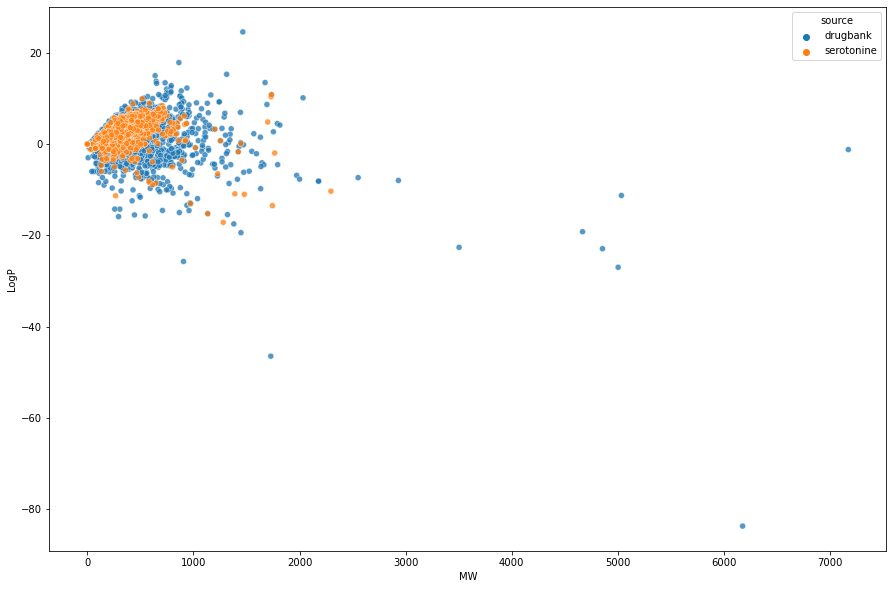

In [24]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [25]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

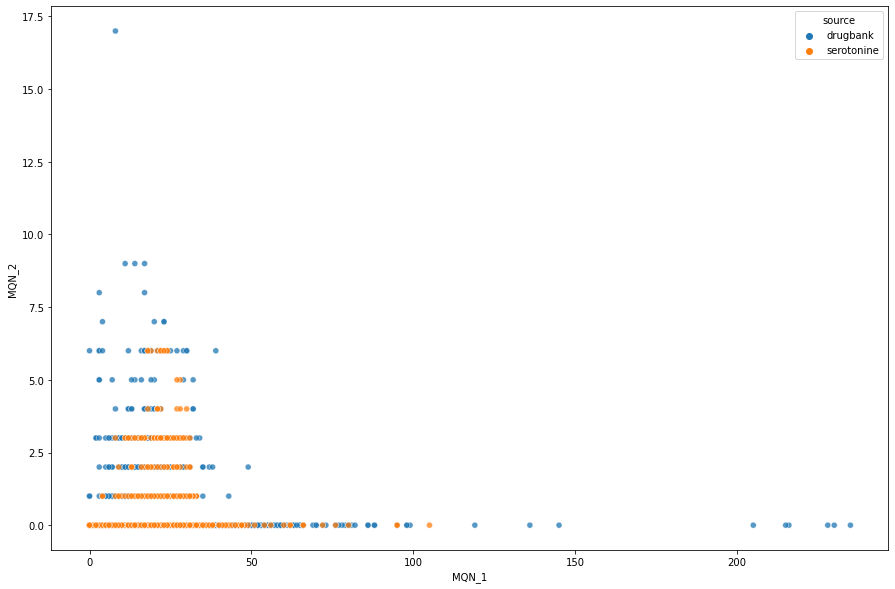

In [26]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# PCA

In [31]:
mqn_columns = [f"MQN_{x}" for x in range(1, 43)]


In [32]:
pca = decomposition.PCA(n_components=42)
pca.fit(df[mqn_columns])
df = df.join(pd.DataFrame(pca.transform(df[mqn_columns]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
            )

In [33]:
len(df.columns)

97

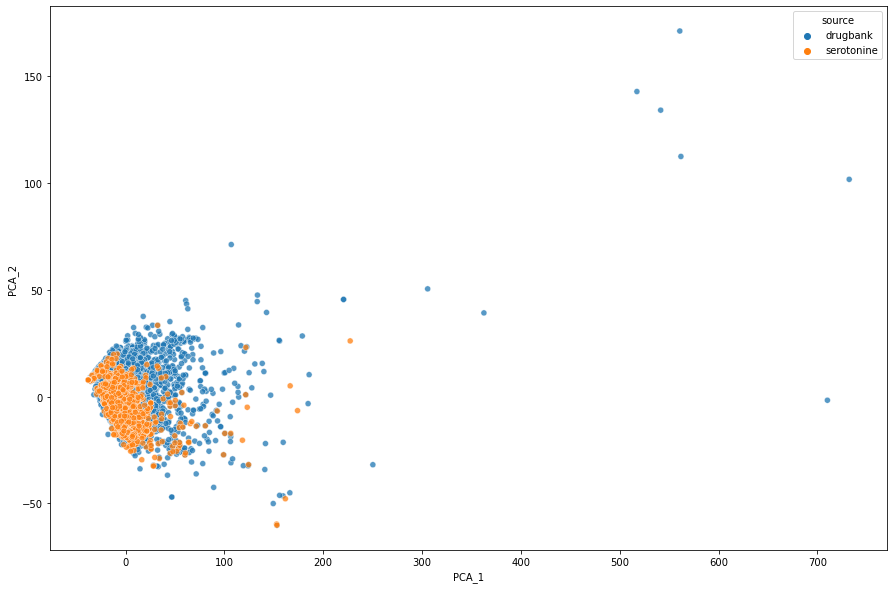

In [34]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1", y="PCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [35]:
norm = preprocessing.normalize(df[mqn_columns])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [36]:
df[mqn_columns].head()

MQN_1  MQN_2  MQN_3  MQN_4  MQN_5  MQN_6  MQN_7  MQN_8  MQN_9  MQN_10  ...  \
0     98      0      0      0      0      0      0     21      3      33  ...   
1     59      0      0      0      0      0      0     13      5      14  ...   
2     46      0      0      0      0      2      0      8      6      12  ...   
3     70      0      1      0      0      0      0     15      2      14  ...   
4     62      0      0      0      0      0      0      0     11      12  ...   

   MQN_33  MQN_34  MQN_35  MQN_36  MQN_37  MQN_38  MQN_39  MQN_40  MQN_41  \
0       0       0       3       3       0       0       0       0       0   
1       0       0       4       2       0       0       0       0       2   
2       0       0       1       2       0       0       0       1       0   
3       0       0       1       5       0       0       0       0       2   
4       0       0       0       0       0       0       0       1       0   

   MQN_42  
0       0  
1       1  
2       0  
3       1  
4       0  

[5 rows x 42 columns]

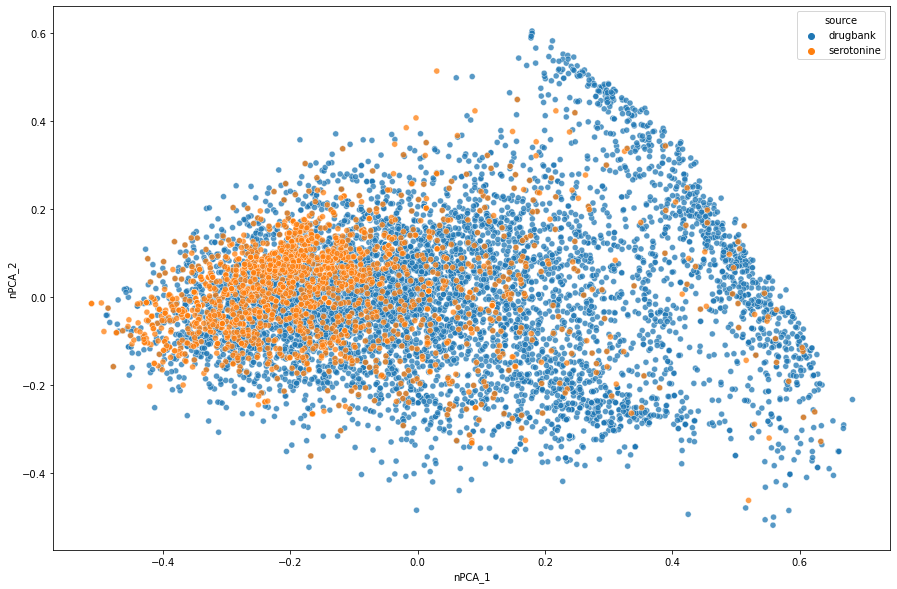

In [37]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# MDS

Interesting, the serotonine set is much more scattered than mtor.

In [38]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [39]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

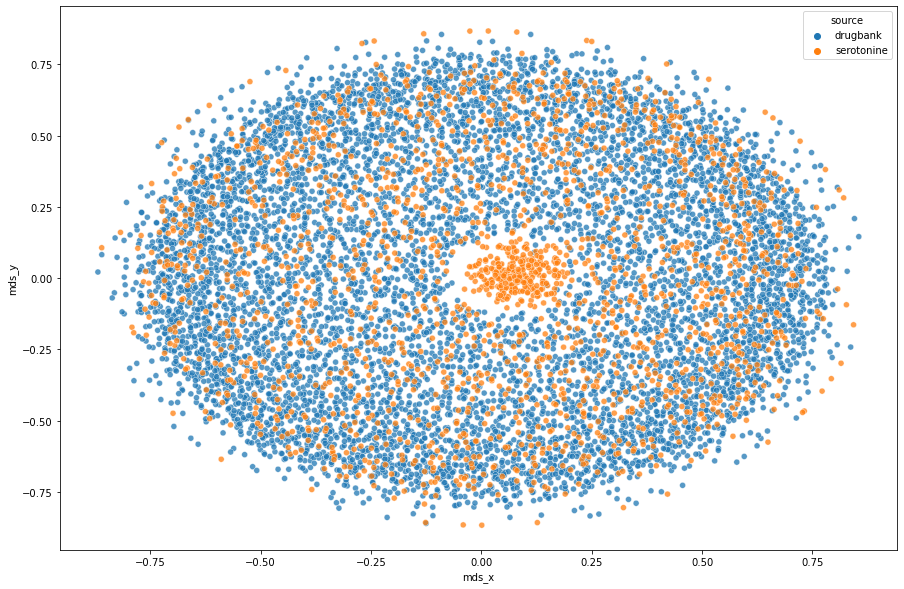

In [40]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Whoa, this is way more mixed up than mMTOR. It seem that the mTOR ligands are much more distinguishable from "general drugs" than the serotonine receptor ligands.

# t-SNE

In [41]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

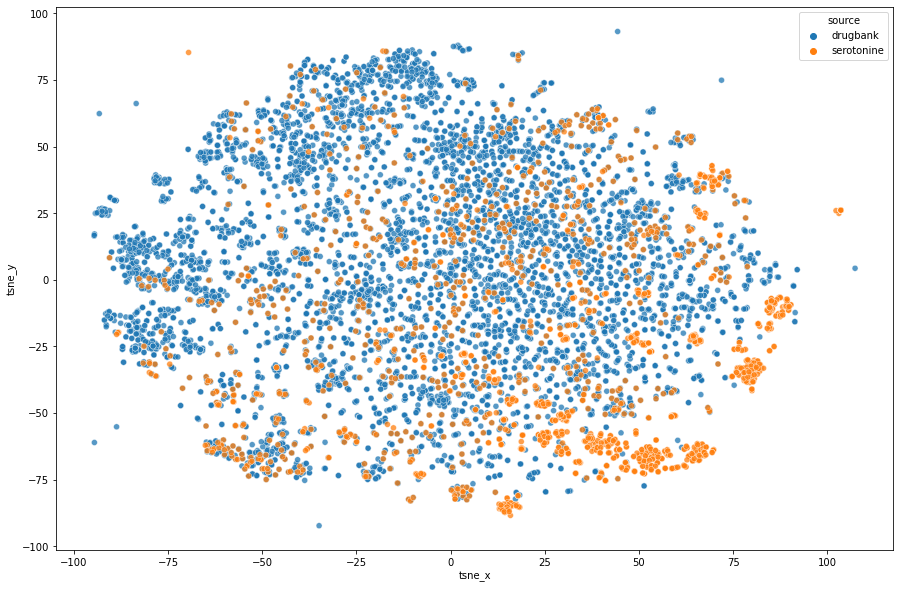

In [42]:
fig, ax = pyplot.subplots(figsize=(15,10))
p = seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Diversity picker

In [43]:
def distance_function(index1, index2, *args, fingerprints=df["fps"], metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [44]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(df), 45))
df["picked"] = df.index.isin(picked)

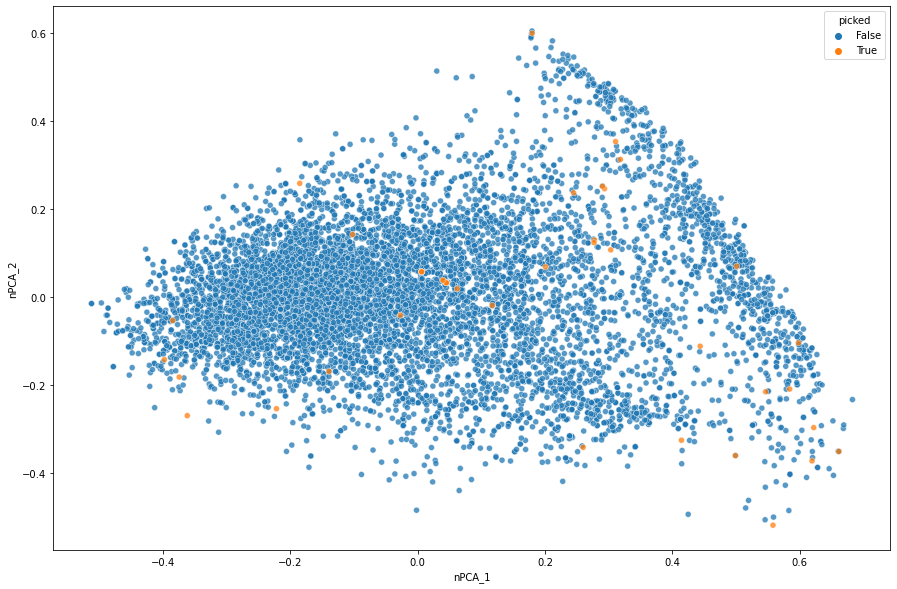

In [45]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("picked"), # True values are drawn as last so they are better visible 
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Why are we picking based on FPS, but visualizing based on MQN (PCA transformed)?

But it looks like the picker did a pretty good job.

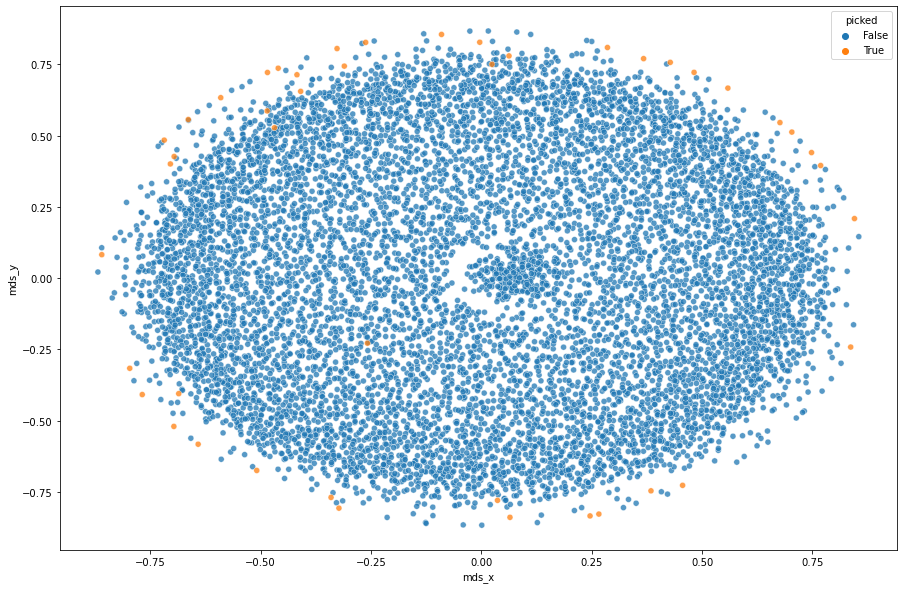

In [46]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

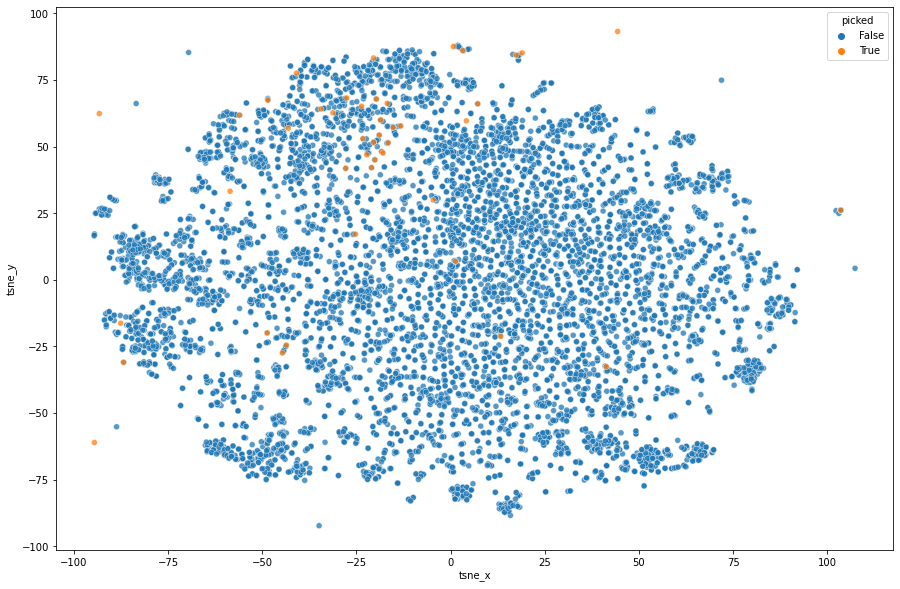

In [47]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Activities or descriptors

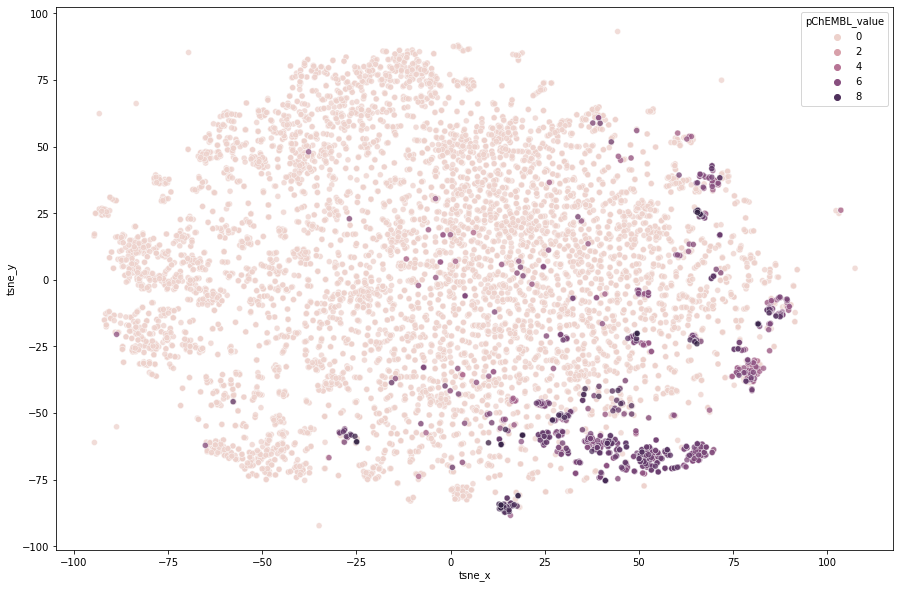

In [48]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

These were activities for everything, now just the serotonine receptor ligand set:

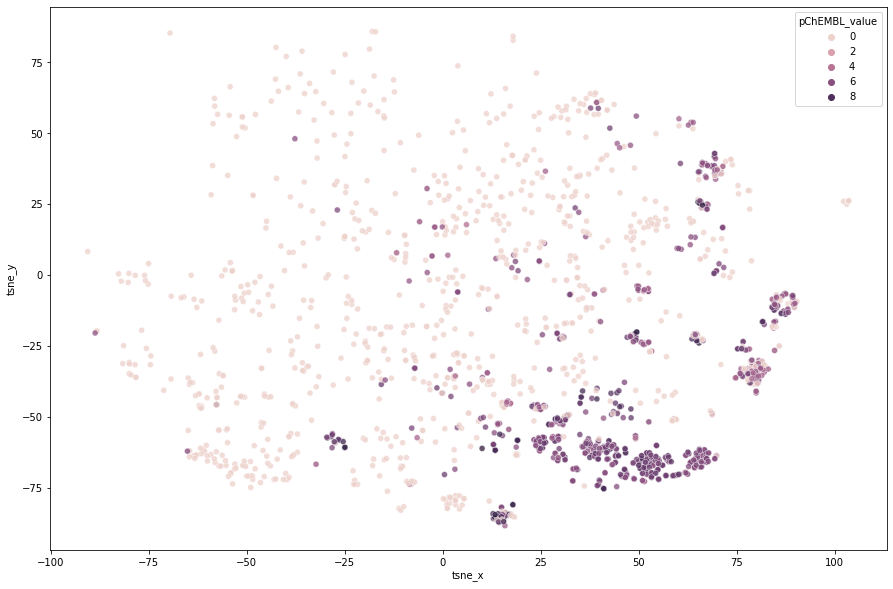

In [49]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df[df.source == "serotonine"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Here it looks like the active ones cluster together.

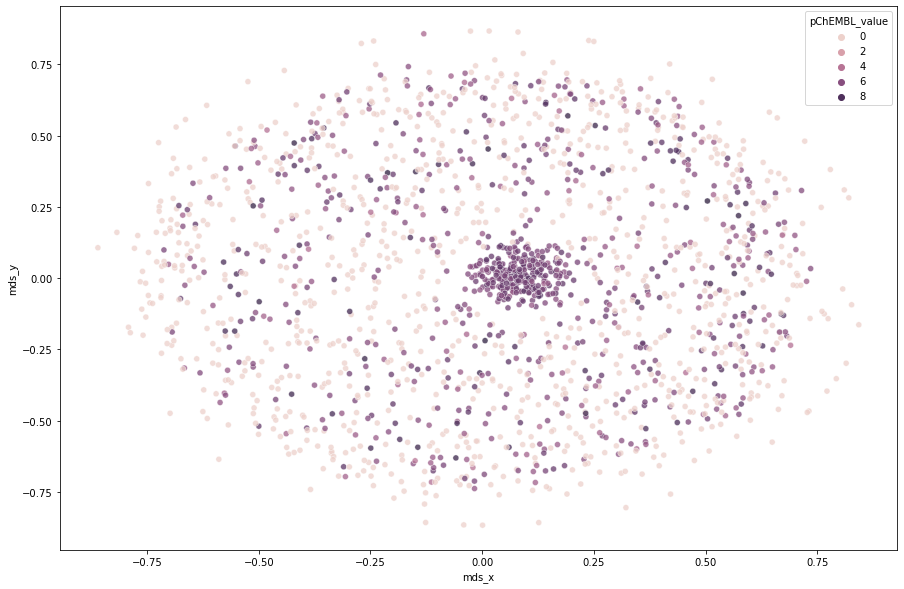

In [50]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df[df.source == "serotonine"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Here not so much...

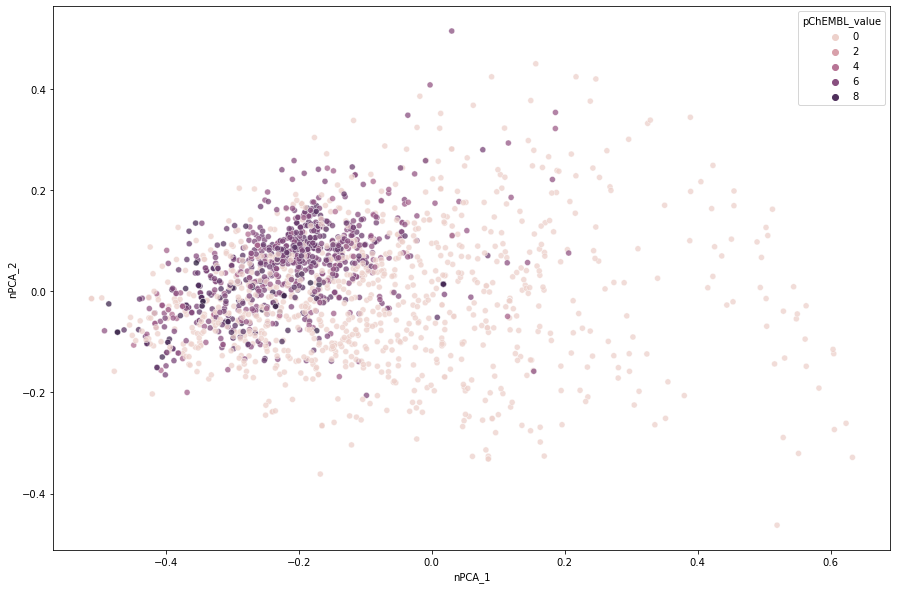

In [51]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "serotonine"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [54]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [58]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol)
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return Chem.MolToSmiles(scaff)

In [59]:
df["scaffold"] = df["rdmol"].apply(scaffold)

In [60]:
scaffold_dict = {}
i = 0
for scaff in df["scaffold"]:
    if scaff not in scaffold_dict:
        scaffold_dict[scaff] = i
        i += 1

In [62]:
def get_id_from_scaffold(smiles):
    return scaffold_dict[smiles]

In [63]:
df["scaffold_id"] = df["scaffold"].apply(get_id_from_scaffold)

## Plot molecules colored by scaffold

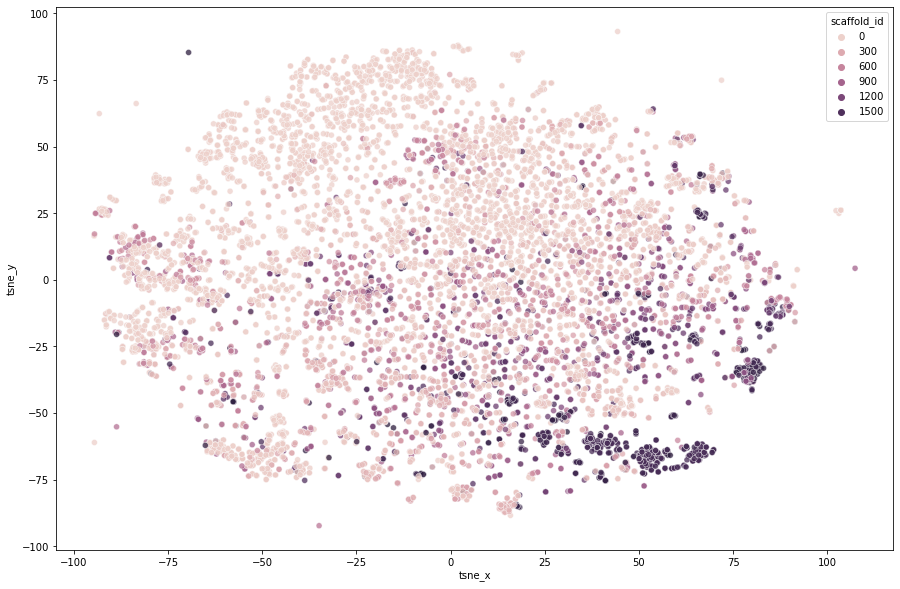

In [64]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="scaffold_id",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

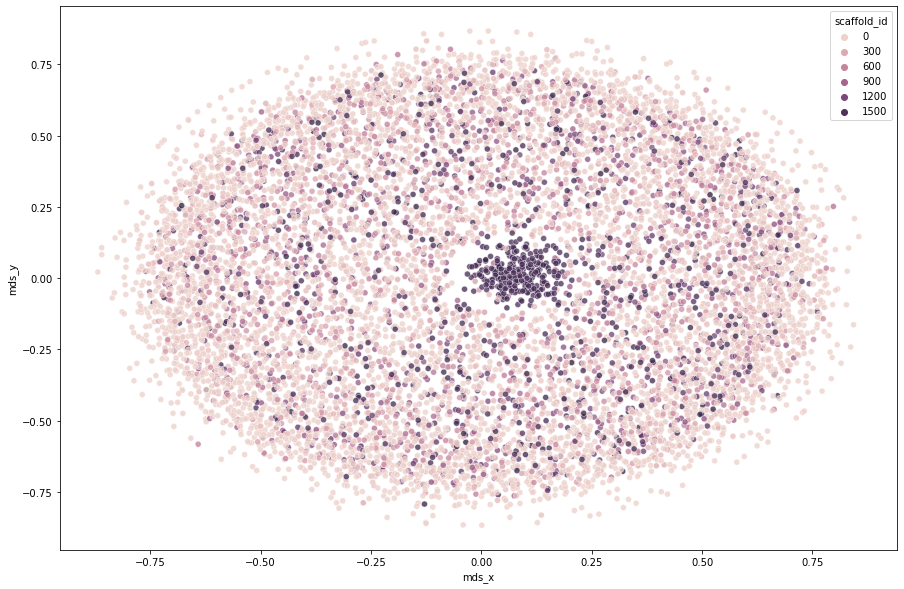

In [65]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="scaffold_id",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )